# Time Series Forecasting

## Bussines Understanding

Notebook ini bertujuan untuk memprediksi kualitas udara harian berdasarkan konsentrasi Nitrogen Dioksida (`NO₂`).
**NO₂** merupakan salah satu indikator utama pencemaran udara yang dihasilkan dari aktivitas transportasi, industri, dan pembakaran bahan bakar fosil. Kadar NO₂ yang tinggi dapat berdampak negatif terhadap kesehatan manusia serta kualitas lingkungan.

Melalui analisis ini, dilakukan pendekatan time series forecasting untuk menganalisis pola perubahan harian konsentrasi NO₂ selama periode 1 bulan pada tanggal 20-09-2025 sd 19-10-2025 di suatu daerah Kota **Probolinggo**. Tujuannya adalah untuk memprediksi kadar NO₂ pada tanggal 20-10-2025.

## Data Understanding
Dataset yang digunakan adalah dataset citra satelit  (NO₂) yang diambil melalui platform [Dataspace Copernicus](https://dataspace.copernicus.eu/). Dokumentasi pengambilan data NO₂ dapat diakses melalui link berikut: [Dokumentasi](https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NO2Covid.html).
Pengambilan titik koordinat suatu daerah dapat menggunakan platform [geojson](https://geojson.io). Pada Notebook ini, digunakan kordinat poligon dari suatu daerah di Kota Probolinggo yang dapat dilihat pada gambar di bawah ini:
![geojson](img/time-series-forecasting/geojson.png 'geojson')

### Mengambil Data
Berikut adalah kode yang digunakan untuk mengambil data berdasarkan kordinat poligon yang sudah didapatkan:

In [1]:
import openeo
from shapely.geometry import shape

ModuleNotFoundError: No module named 'openeo'

In [ ]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

In [ ]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [113.18, -7.75],
            [113.18, -7.82],
            [113.25, -7.82],
            [113.25, -7.75],
            [113.18, -7.75],
        ]
    ],
}

In [ ]:
prob = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2025-09-20", "2025-10-20"],
    spatial_extent={
        "west":113.18,
        "south":-7.82,
        "east":113.25,
        "north":-7.75
    },
    bands=["NO2"],
)

In [ ]:
feature = {"type":"Feature", "geometry": aoi, "properties": {"id": 1}}
fc = {"type": "FeatureCollection", "features": [feature]}

In [ ]:
# Now aggregate by day to avoid having multiple data per day
prob = prob.aggregate_temporal_period(reducer="mean", period="day")

# let's create a spatial aggregation to generate mean timeseries data
prob = prob.aggregate_spatial(reducer="mean", geometries=fc)

In [ ]:
job = prob.execute_batch(title="NO2 Kota Problinggo Sep-Okt 2025", outputfile="no2.nc")

### Convert to CSV
Dataset yang dihasilkan berupa file NetCDF (.nc). Untuk mempermudah pemrosesan data kita perlu konversi menjadi format dataset umum seperti (.csv). Berikut adalah kode yang dapat digunakan untuk mengonversi file (.nc) ke (.csv):

In [ ]:
import xarray as xr

In [ ]:
# open dataset NetCDF
ds = xr.open_dataset("timeseries.nc")

# lihat isi untuk menyesuaikan transformasi
print(ds)

df = ds.to_dataframe().reset_index()

# Ambil kolom waktu dan NO2
df = df[['t', 'NO2']]

# Simpan ke CSV
df.to_csv("NO2.csv", index=False)

### Exploratory Data Analysis (EDA)
Setelah berhasil mendapatkan data dalam bentuk (.csv), langkah selanjutnya adalah melihat/mengeksplor kondisi data 

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [34]:
no2_asli = pd.read_csv('../datasets/no2.csv')
no2_asli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    27 non-null     object 
 1   NO2     27 non-null     float64
dtypes: float64(1), object(1)
memory usage: 560.0+ bytes


In [35]:
# Ubah kolom 'date' menjadi tipe datetime
no2_asli['date'] = pd.to_datetime(no2_asli['date'])
no2_asli.info()

no2 = no2_asli.copy()

# Urutkan data berdasarkan tanggal
no2 = no2.sort_values('date')

# Set kolom 'date' sebagai index
no2 = no2.set_index('date')
print(no2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    27 non-null     datetime64[ns]
 1   NO2     27 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 560.0 bytes
                 NO2
date                
2025-09-20  0.000091
2025-09-21  0.000029
2025-09-22  0.000033
2025-09-23  0.000039
2025-09-24  0.000033


In [36]:
# MEMERIKSA MISSING DATES

# Cek rentang tanggal lengkap (harian)
tanggal_lengkap = pd.date_range(start=no2.index.min(), end=no2.index.max(), freq='D')

print(tanggal_lengkap)

# Cari tanggal yang hilang
tanggal_hilang = tanggal_lengkap.difference(no2.index)

print("Tanggal yang hilang:\n", tanggal_hilang)

DatetimeIndex(['2025-09-20', '2025-09-21', '2025-09-22', '2025-09-23',
               '2025-09-24', '2025-09-25', '2025-09-26', '2025-09-27',
               '2025-09-28', '2025-09-29', '2025-09-30', '2025-10-01',
               '2025-10-02', '2025-10-03', '2025-10-04', '2025-10-05',
               '2025-10-06', '2025-10-07', '2025-10-08', '2025-10-09',
               '2025-10-10', '2025-10-11', '2025-10-12', '2025-10-13',
               '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-19'],
              dtype='datetime64[ns]', freq='D')
Tanggal yang hilang:
 DatetimeIndex(['2025-09-29', '2025-10-11', '2025-10-16'], dtype='datetime64[ns]', freq=None)


Dari pengecekan di atas. Terdapat missing date pada tanggal ['2025-09-29', '2025-10-11', '2025-10-16']. Missing dates tersebut perlu kita proses terlebih dulu, karena missing value pada time series akan sangat berpengaruh terhadap akurasi model nantinya.

## Pre-Processing
Tahap ini akan melakukan proses awal data untuk menangani missing dates yang sudah ditemukan pada tahap Data Understanding serta mengubah data Time Series menjadi data Supervied.

### Menangani Missing Value
Dates yang hilang akan ditambahkan dan value NO2 pada dates baru akan diisi menggunakan teknik Interpolasi linear.

In [37]:
# Reindex dataframe agar semua tanggal muncul
no2 = no2.reindex(tanggal_lengkap)
print(no2.head(10))

# Interpolasi nilai yang hilang (linear interpolation)
no2 = no2.interpolate(method='linear')

# Reset index dan ubah nama kolom index ke 'date' kembali
no2 = no2.reset_index().rename(columns={'index': 'date'})

# Cek hasil
# print(no2.head())
print("\nJumlah missing value setelah interpolasi:")
print(no2.isna().sum())

                 NO2
2025-09-20  0.000091
2025-09-21  0.000029
2025-09-22  0.000033
2025-09-23  0.000039
2025-09-24  0.000033
2025-09-25  0.000032
2025-09-26  0.000059
2025-09-27  0.000048
2025-09-28  0.000012
2025-09-29       NaN

Jumlah missing value setelah interpolasi:
date    0
NO2     0
dtype: int64


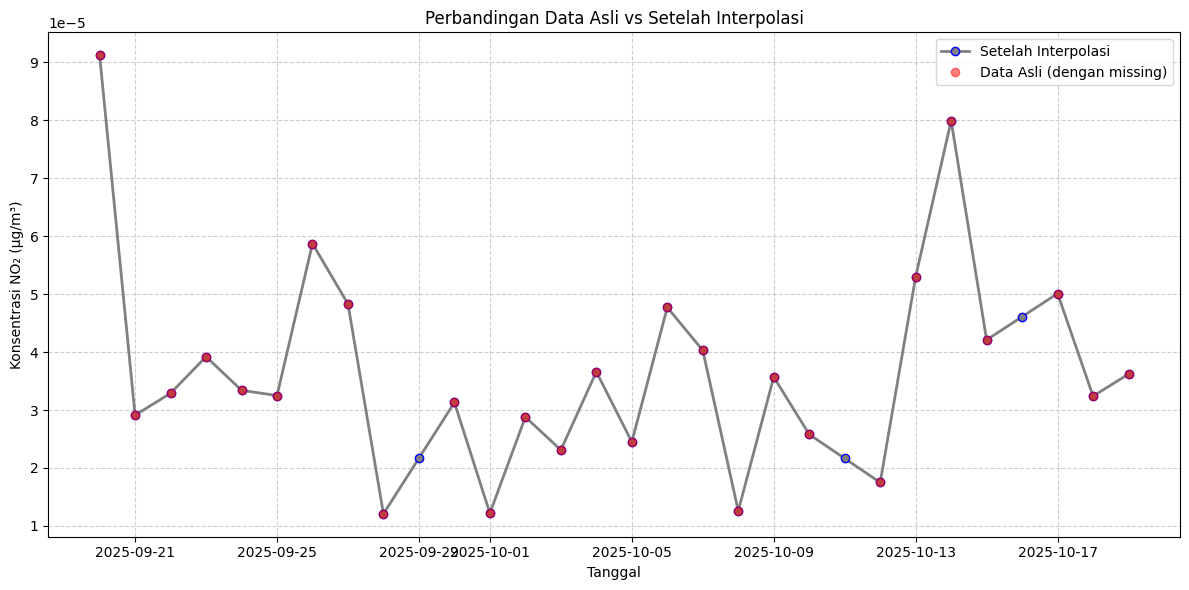

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(no2['date'], no2['NO2'], linestyle='-', color='grey', linewidth=2,  marker='o', markeredgecolor='blue', label='Setelah Interpolasi')
plt.plot(no2_asli['date'], no2_asli['NO2'], 'ro', alpha=0.5, label='Data Asli (dengan missing)')
plt.title('Perbandingan Data Asli vs Setelah Interpolasi')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Dari visualisasi grafik di atas, dapat dilihat untuk titik lingkaran berwarna biru menunjukkan data baru hasil interpolasi linear. Data yang semula memiliki missing dates, yaitu berjumlah 27 data, sudah berhasil ditangani sehingga sekarang berjumlah lengkap 30 data. 

### Mengubah Data menjadi Supervised
Pada tahap ini, data time series yang sudah lengkap akan diubah menjadi data supervised menggunakan teknik sliding windows. Teknik ini sederhananya memanfaatkan data masa lalu menjadi fitur/input. Misalnya kita akan memanfaatkan hari kemarin (t-2), hari ini (t-1) sebagai fitur untuk memprediksi hari esok (t). Data masa lalu atau disebut sebagai **lag** ukurannya bisa menyesuaikan dengan data masing-masing untuk mendapat akurasi terbaik. Pada eksperimen yang saya lakukan, ukuran terbaiknya adalah 4, jadi pada notebook ini data supervised memanfaatkan 4 hari masa lalu untuk memprediksi hari berikutnya.


In [39]:
supervised = pd.DataFrame()
# supervised['t-7'] = no2['NO2'].shift(7)
# supervised['t-6'] = no2['NO2'].shift(6)
# supervised['t-5'] = no2['NO2'].shift(5)
supervised['t-4'] = no2['NO2'].shift(4)
supervised['t-3'] = no2['NO2'].shift(3)
supervised['t-2'] = no2['NO2'].shift(2)
supervised['t-1'] = no2['NO2'].shift(1)
supervised['t'] = no2['NO2']

In [40]:
supervised = supervised.dropna().reset_index(drop=True)
print(supervised.head())

        t-4       t-3       t-2       t-1         t
0  0.000091  0.000029  0.000033  0.000039  0.000033
1  0.000029  0.000033  0.000039  0.000033  0.000032
2  0.000033  0.000039  0.000033  0.000032  0.000059
3  0.000039  0.000033  0.000032  0.000059  0.000048
4  0.000033  0.000032  0.000059  0.000048  0.000012


### Normalisasi Data
Pada tahap ini data supervised yang sudah dihasilkan akan dinormalisasi menggunakan teknik `MinMaxScaler`. MinMaxScaler akan mengubah fitur (kolom data) dengan menskalakan setiap nilai dalam rentang tertentu, biasanya antara 0 dan 1. Pada notebook ini, range yang akan digunakan antara 0 dan 1. Jadi nilai minimum fitur asli akan menjadi 0, dan nilai maksimum fitur asli akan menjadi 1.

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_values = scaler.fit_transform(supervised)
scaled = pd.DataFrame(scaled_values, columns=supervised.columns)

print(scaled.head())

        t-4       t-3       t-2       t-1         t
0  1.000000  0.250737  0.306785  0.399705  0.314159
1  0.214918  0.306785  0.399705  0.314159  0.300885
2  0.262958  0.399705  0.314159  0.300885  0.687316
3  0.342604  0.314159  0.300885  0.687316  0.533923
4  0.269279  0.300885  0.687316  0.533923  0.000000


## Modeling
Pada tahap ini, kita akan menggunakan model `KNN Regressor` yang disediakan oleh library Sklearn untuk training dan testing data. Selanjutkan kita akan ukur akurasi model menggunakan `Mean Squared Error (MSE)` dan `R^2`.

In [42]:
X = scaled.drop('t', axis=1)
y = scaled['t']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [44]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 0.0910
R^2 Score: -0.4496


Dapat dilihat dari hasil prediksi, meskipun rata-rata kesalahannya (MSE) tidak terlalu besar, tapi pola prediksinya belum cukup baik melihat hubungan antarhari dengan baik. Artinya model masih perlu diperbaiki misalnya dengan menambah data, menyesuaikan jumlah tetangga (K), atau menambah lag fitur. Akurasi yang buruk ini bisa jadi disebabkan oleh jumlah data yang digunakan terlalu sedikit. Hasil prediksi tersebut sudah paling baik dari eksperimen lag fitur dan jumlah neighbors pada dataset yang digunakan.

In [45]:
result = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

print("\nContoh hasil prediksi:")
print(result.head())


Contoh hasil prediksi:
     Actual  Predicted
0  0.079646   0.350400
1  0.603245   0.303519
2  1.000000   0.326380
3  0.442478   0.304046
4  0.501475   0.287189


Dari hasil training model yang sudah dilakukan, berikut adalah hasil prediksi untuk tanggal 20-10-2025:

In [46]:
last_input = scaled.drop('t', axis=1).iloc[-1].values.reshape(1, -1)
next_pred_scaled = knn.predict(last_input)
next_pred = scaler.inverse_transform(
    np.hstack((last_input, next_pred_scaled.reshape(-1, 1)))
)[0, -1]

# Buat tanggal baru untuk prediksi
next_date = (pd.to_datetime(no2['date'].iloc[-1]) + pd.Timedelta(days=1)).date()

print(f'\nPrediksi NO2 pada {next_date}: {next_pred}')


Prediksi NO2 pada 2025-10-20: 3.157142857142857e-05


c:\Users\Muhammad Junaidi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


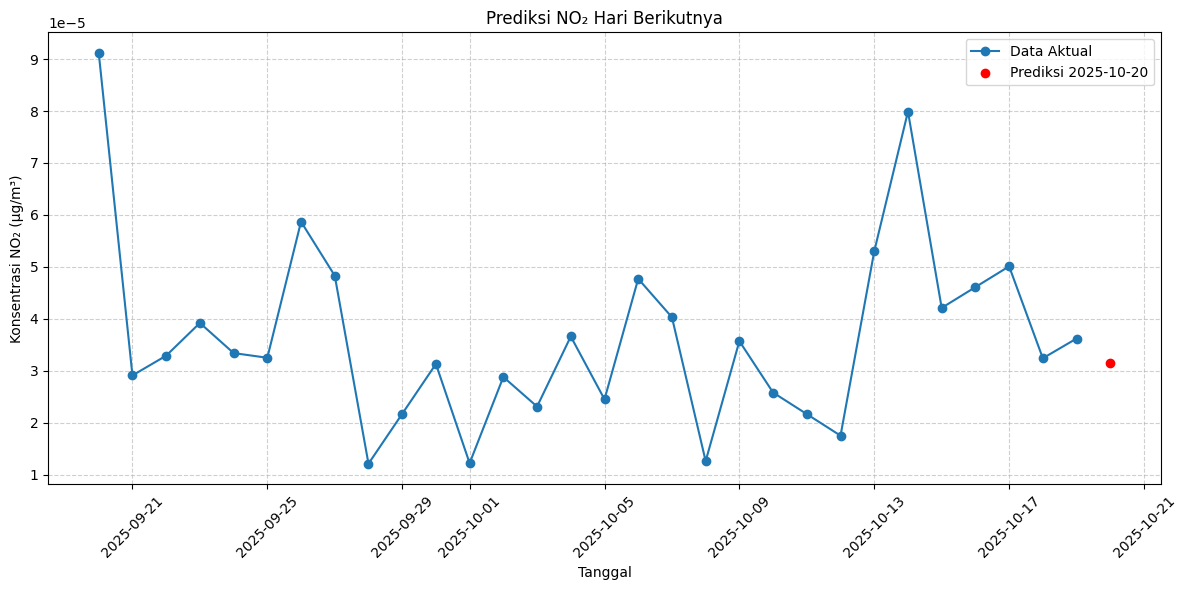

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(no2['date'], no2['NO2'], marker='o', label='Data Aktual')
plt.scatter(next_date, next_pred, color='red', label=f'Prediksi {next_date}')

plt.title('Prediksi NO₂ Hari Berikutnya')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
